In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Cargamos dataset
df_verificacion = pd.read_csv("data/Movimientos_limpios.csv", parse_dates=['fecha_operacion'])
display(df_verificacion.sample(10))

,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes
959,2024-01-23,"Pago Movil En Papparazi Arena, Palmas De Gra, ...",-54.60,pago movil en papparazi arena palmas de gra tarj,gasto,2024-01
1721,2022-02-11,"TRANSACCION CONTACTLESS EN FRIKI BAR SCP, LAS ...",-10.00,transaccion contactless en friki bar scp las p...,gasto,2022-02
1981,2022-09-02,"PAGO MOVIL EN HD ARNAO, TELDE, TARJ. :*585729",-5.19,pago movil en hd arnao telde tarj,gasto,2022-09
1279,2023-08-31,"Transaccion Contactless En Lidl Can-gc-tel, Ll...",-29.17,transaccion contactless en lidl can gc tel lla...,gasto,2023-08
487,2024-07-18,"Compra Internet En Repsol Waylet, Madrid, Tarj...",-19.21,compra internet en repsol waylet madrid tarj,gasto,2024-07
1810,2022-04-20,"TRANSACCION CONTACTLESS EN MINIMARKET LA X, LA...",-0.50,transaccion contactless en minimarket la x las...,gasto,2022-04
1710,2022-02-01,RECIBO LAS PALMAS VEGUETA N: RECIBO 0049 6140 ...,-29.90,recibo las palmas vegueta n recibo bbdtlpb ref...,gasto,2022-02
1260,2023-10-06,"Pago Movil En Hd Melenara, Telde, Tarj. :*179057",-55.19,pago movil en hd melenara telde tarj,gasto,2023-10
493,2024-07-16,"Pago Movil En Primor El Mirad, Las Palmas De, ...",-28.48,pago movil en primor el mirad las palmas de tarj,gasto,2024-07
2069,2022-10-30,"PAGO MOVIL EN MC DONALD LAS T, HORNOS DEL RE, ...",-2.50,pago movil en mc donald las t hornos del re tarj,gasto,2022-10


In [4]:
# Creamos copia para no dañar base original 
df_categorias = df_verificacion.copy()

# Clasificación


In [5]:
# Creamos funcion para crear las categorias y entrenar el modelo de categorización
def clasificar_por_reglas(texto):
    texto = str(texto).lower()

    # Ingresos
    if any(p in texto for p in ['transferencia inmediata de', 'transferencia de', 'transferencia recibida', 'reintegro']):
        return 'Ingreso'
    if 'bizum de' in texto:
        return 'Ingreso'

    # Cuentas pagadas / personales
    if 'bizum a' in texto or 'transferencia a' in texto or 'traspaso' in texto:
        return 'Transferencia personal'
    
    # Facturas
    if 'recibo' in texto or 'academia' in texto or 'univ' in texto:
        return 'Facturas'

    # Préstamos
    if 'liquidacion periodica' in texto:
        return 'Préstamo'
    
    # Compras no esenciales
    compras_no_esenciales = [
        'mediamarkt', 'media markt', 'fnac','ikea', 'leroy merlin', 'decathlon',
        'zara', 'shein', 'aliexpress', 'pull&bear', 'stradivarius', 'amazon', 'playstation',
        'viveros', 'zara home', 'idea market', 'playstation', 'tabaco', 'kiwoko',
        'primor', 'agroquimica', 'druni','kiwoko'
    ]
    if any(c in texto for c in compras_no_esenciales):
        return 'Compras no esenciales'

    # Restauración
    restaurantes = [
        'la sureña', 'goiko', 'vips', 'heladeria','pizza', 'hamburguesa','heladería', 'picoteo',
        'mcdonald', 'mc donald', 'burger king', 'burguer king', 'los charcones',
        'quinta cumbre', 'bk', 'camaleon', 'tagliatella', 'bar', 'cafeteria',
        'cafetería', 'food', 'tb metropo', 'compra uber', "llaollao", "compra sumup",
        'pasteleria', 'poke','las casitas', 'gelato', 'cantina', 'nothing', 'oakberry', 'restaurante'
    ]
    if any(r in texto for r in restaurantes):
        return 'Restauración'
    
    # Veterinario
    if 'el corral' in texto:
        return 'Facturas'

    # Supermercado
    supermercado = ['mercadona', 'aldi', 'lidl', 'hiperdino', 'carrefour', 'alcampo', 'farmacia']
    if any(s in texto for s in supermercado):
        return 'Supermercado'

    # Suscripciones / ocio
    ocio = ['netflix', 'spotify', 'hbo', 'disney+', 'disney plus', 'amazon prime', 'filmin', 'nintendo', 'game pass', 'cine', 'artesiete', 'apple com']
    if any(o in texto for o in ocio):
        return 'Ocio / Suscripciones'

    
    # Transporte público
    if any(p in texto for p in ['guaguas', 'salcai', 'global']):
        return 'Transporte'

    # Transporte privado / gasolina
    gasolina = ['repsol', 'cepsa', 'bp', 'shell', 'gasolinera', 'disa', 'parking', 'motor telde', 'coche', 'rueda', 'gasolina', 'petroprix']
    if any(g in texto for g in gasolina):
        return 'Transporte'


    return 'Sin categorizar'

df_categorias["categoria"] = df_categorias["operacion_limpia"].apply(clasificar_por_reglas)
display(df_categorias[df_categorias["categoria"] == "Sin categorizar"])

,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes,categoria
13,2025-04-21,"Pago Movil En Hd Melenara, Telde, Tarj. :*179057",-105.04,pago movil en hd melenara telde tarj,gasto,2025-04,Sin categorizar
22,2025-04-14,"Pago Movil En Fruta Y Verdura, Valsequillo, Ta...",-12.19,pago movil en fruta y verdura valsequillo tarj,gasto,2025-04,Sin categorizar
24,2025-04-14,"Pago Movil En E.s. Las Terraz, Hornos Del Re, ...",-10.00,pago movil en e s las terraz hornos del re tarj,gasto,2025-04,Sin categorizar
26,2025-04-14,"Pago Movil En Domyhome, Telde, Tarj. :*179057",-1.50,pago movil en domyhome telde tarj,gasto,2025-04,Sin categorizar
28,2025-04-07,"Compra Nyx*airservspain, Sansebastiand, Tarjet...",-1.00,compra nyx airservspain sansebastiand tarjeta ...,gasto,2025-04,Sin categorizar
...,...,...,...,...,...,...,...
2340,2023-04-22,"PAGO MOVIL EN HD ARNAO, TELDE, TARJ. :*585729",-8.13,pago movil en hd arnao telde tarj,gasto,2023-04,Sin categorizar
2341,2023-04-22,"PAGO MOVIL EN LACANDELLA, LAS PALMAS DE, TARJ....",-20.00,pago movil en lacandella las palmas de tarj,gasto,2023-04,Sin categorizar
2357,2023-05-08,"PAGO MOVIL EN HD MELENARA, TELDE, TARJ. :*585729",-75.88,pago movil en hd melenara telde tarj,gasto,2023-05,Sin categorizar
2360,2023-05-06,"PAGO MOVIL EN SHALOM RESTAURA, TEROR, TARJ. :*...",-7.90,pago movil en shalom restaura teror tarj s a l...,gasto,2023-05,Sin categorizar


# Preparación del Modelo

In [6]:
# 1 Preparar los datos seleccionando los clasificados
df_etiquetado = df_categorias[df_categorias['categoria'] != 'Sin categorizar'].copy()
display(df_etiquetado.sample(10))

,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes,categoria
1501,2023-05-17,"Pago Movil En El Corral Telde, Telde, Tarj. :*...",-145.11,pago movil en el corral telde telde tarj,gasto,2023-05,Facturas
724,2024-04-17,Traspaso: Ahorro Hucha Objetivo: Regalo,-2.02,traspaso ahorro hucha objetivo regalo,gasto,2024-04,Transferencia personal
691,2024-04-29,"Pago Movil En Parking, Palmas De Gra, Tarj. :*...",-4.90,pago movil en parking palmas de gra tarj,gasto,2024-04,Transporte
1505,2023-05-15,Bizum De Debora Vega Ravelo Concepto .,43.00,bizum de debora vega ravelo concepto,ingreso,2023-05,Ingreso
459,2024-07-30,"Pago Movil En Quinta Cumbre A, Las Palmas De, ...",-10.20,pago movil en quinta cumbre a las palmas de tarj,gasto,2024-07,Restauración
603,2024-06-10,"Compra Playstation Network, Hilversum, Tarjeta...",-8.99,compra playstation network hilversum tarjeta c...,gasto,2024-06,Compras no esenciales
1228,2023-10-19,Transferencia De Gomez Bastidas Oscar Alejandr...,3.41,transferencia de gomez bastidas oscar alejandro,ingreso,2023-10,Ingreso
349,2024-10-14,"Compra Internet En Repsol Waylet, Madrid, Tarj...",-14.63,compra internet en repsol waylet madrid tarj,gasto,2024-10,Transporte
282,2024-11-18,Bizum A Favor De Debora Vega Ravelo Concepto: ...,-36.60,bizum a favor de debora vega ravelo concepto agua,gasto,2024-11,Transferencia personal
1691,2022-01-25,TRANSFERENCIA DE EVELYMAR ESPERANZA BASTIDAS R...,175.00,transferencia de evelymar esperanza bastidas r...,ingreso,2022-01,Ingreso


In [7]:
# 2 Separar texto y etiquetas
x_texto = df_etiquetado['operacion_limpia']
y_etiqueta = df_etiquetado['categoria']

In [ ]:
# 3. Guardar los textos en una lista para revisarlos luego
textos_originales = x_texto.tolist()

In [ ]:
#4 Vectorizar el texto con TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_vect = vectorizer.fit_transform(x_texto)

In [ ]:
# 5 Entrenar el modelo
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, x_text_train, x_text_test = train_test_split(
    X_vect, y_etiqueta, textos_originales, test_size=0.2, random_state=42
)

In [ ]:
# 6 Crear el arbol de clasificación
from sklearn.ensemble import RandomForestClassifier

modelo= RandomForestClassifier()
modelo.fit(x_train, y_train)

RandomForestClassifier()

# Aplicación

Accuracy 0.9810725552050473
Reporte de clasificación:
                        precision    recall  f1-score   support

 Compras no esenciales       1.00      0.87      0.93        23
              Facturas       1.00      1.00      1.00        30
               Ingreso       1.00      1.00      1.00        82
  Ocio / Suscripciones       0.92      1.00      0.96        24
              Préstamo       1.00      1.00      1.00         4
          Restauración       0.93      1.00      0.96        52
          Supermercado       1.00      0.97      0.98        33
Transferencia personal       1.00      1.00      1.00        35
            Transporte       1.00      0.94      0.97        34

              accuracy                           0.98       317
             macro avg       0.98      0.98      0.98       317
          weighted avg       0.98      0.98      0.98       317



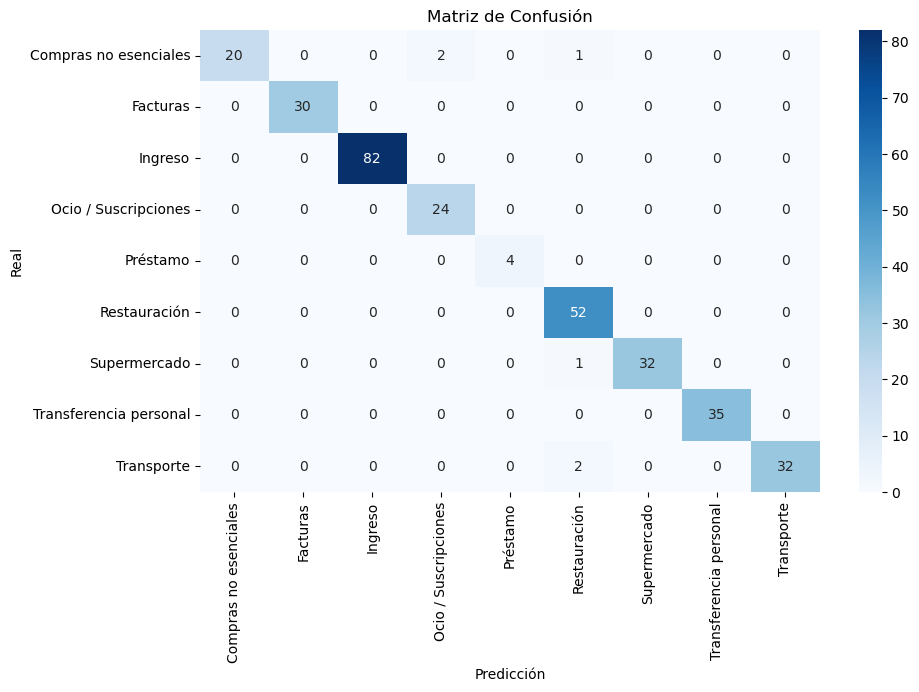

,texto,real,predicho
14,pago movil en est cepsa hoya palmas las tarj,Transporte,Restauración
160,pago movil en est cepsa hoya palmas las tarj,Transporte,Restauración
204,compra pago m vil en tabaco barato telde tarj,Compras no esenciales,Restauración
257,compra playstationnetwork london tarjeta comision,Compras no esenciales,Ocio / Suscripciones
295,pago movil en farmacia la esq telde tarj,Supermercado,Restauración
302,compra playstationnetwork london tarjeta comision,Compras no esenciales,Ocio / Suscripciones


In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predice sobre el conjunto de prueba
y_pred = modelo.predict(x_test)

# Exactitud global
print('Accuracy', accuracy_score(y_test, y_pred))

# Informe por clase
print('Reporte de clasificación:')
print(classification_report(y_test, y_pred))

# Matriz de confusión 
import seaborn as sns 

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=modelo.classes_, yticklabels=modelo.classes_, cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# 7. Revisar predicciones incorrectas
errores = pd.DataFrame({
    'texto': x_text_test,
    'real': y_test.values,
    'predicho': y_pred
})
errores = errores[errores['real'] != errores['predicho']]

# Mostrar errores
display(errores.head(15))

# Categorizar los movimientos faltantes con el modelo

In [12]:
# Seleccionar solo los movimientos sin categoría
df_sin_etiquetar = df_categorias[df_categorias['categoria'] == 'Sin categorizar'].copy()


In [13]:
# Vectorizar esos nuevos textos con el vectorizer que ya tienes
x_nuevos = vectorizer.transform(df_sin_etiquetar['operacion_limpia'])

In [14]:
# predecir las categorías
df_sin_etiquetar['categoria_predicha'] = modelo.predict(x_nuevos)

In [15]:
# Ver los resultados
display(df_sin_etiquetar[['operacion_limpia', 'categoria_predicha']].sample(15))
df_sin_etiquetar.info()
df_sin_etiquetar[df_sin_etiquetar['categoria'] == 'Sin categorizar'].shape[0]

,operacion_limpia,categoria_predicha
1232,compra rockabilly venegas las palmas de tarjet...,Restauración
1793,pago movil en gicha bubble te las palmas de tarj,Compras no esenciales
251,pago movil en laiba doner keb telde tarj,Supermercado
408,compra tb las arenas cle las palmas tarjeta co...,Restauración
482,pago movil en laiba doner keb telde tarj,Supermercado
1120,pago movil en hd melenara telde tarj,Supermercado
1843,pago movil en floristeria ela almendros ur tarj,Restauración
1912,pago movil en la mareta telde tarj,Restauración
64,compra pago m vil en la andaluza las palmas de...,Transporte
494,pago movil en piscolabis la v aguimes tarj,Restauración


<class 'pandas.core.frame.DataFrame'>
Index: 781 entries, 9 to 2361
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   fecha_operacion     781 non-null    datetime64[ns]
 1   operacion           781 non-null    object        
 2   importe             781 non-null    float64       
 3   operacion_limpia    781 non-null    object        
 4   tipo                781 non-null    object        
 5   año_mes             781 non-null    object        
 6   categoria           781 non-null    object        
 7   categoria_predicha  781 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 54.9+ KB


781

In [16]:
# 4. Actualizar el DataFrame original usando índices
df_categorias.loc[df_sin_etiquetar.index, 'categoria'] = df_sin_etiquetar['categoria_predicha'].values

# 5. Añadir columna origen
df_categorias['origen'] = 'manual'
df_categorias.loc[df_sin_etiquetar.index, 'origen'] = 'modelo'
display(df_categorias.sample(15))
df_categorias[df_categorias['categoria'] == 'Sin categorizar'].shape[0]

df_categorias.info()

,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes,categoria,origen
2106,2023-08-31,"Transaccion Contactless En Hd Melenara, Telde,...",-40.50,transaccion contactless en hd melenara telde tarj,gasto,2023-08,Supermercado,modelo
331,2022-06-12,"TRANSACCION CONTACTLESS EN HELADERIA QUINT, TE...",-6.80,transaccion contactless en heladeria quint tel...,gasto,2022-06,Restauración,manual
2333,2023-05-15,"Pago Movil En Alcampo Telde, Telde, Tarj. :*58...",-46.97,pago movil en alcampo telde telde tarj,gasto,2023-05,Supermercado,manual
1655,2024-03-05,Traspaso: Ahorro Hucha Objetivo: Regalo,-2.00,traspaso ahorro hucha objetivo regalo,gasto,2024-03,Transferencia personal,manual
1362,2024-07-01,"Pago Movil En Hd Melenara, Telde, Tarj. :*179057",-48.37,pago movil en hd melenara telde tarj,gasto,2024-07,Supermercado,modelo
1487,2024-05-13,"Compra Internet En Repsol Waylet, Madrid, Tarj...",-28.97,compra internet en repsol waylet madrid tarj,gasto,2024-05,Transporte,manual
2191,2023-07-28,Transferencia De Fundacion Canaria Universidad...,358.65,transferencia de fundacion canaria universidad...,ingreso,2023-07,Ingreso,manual
796,2023-04-15,"PAGO MOVIL EN LACANDELLA, LAS PALMAS DE, TARJ....",-29.10,pago movil en lacandella las palmas de tarj,gasto,2023-04,Restauración,modelo
1372,2024-07-01,Traspaso: Ahorro Hucha Objetivo: Regalo,-15.10,traspaso ahorro hucha objetivo regalo,gasto,2024-07,Transferencia personal,manual
770,2023-03-29,"COMPRA INTERNET EN ARTESIETE LAS T, HORNOS DEL...",-9.80,compra internet en artesiete las t hornos del ...,gasto,2023-03,Ocio / Suscripciones,manual


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fecha_operacion   2362 non-null   datetime64[ns]
 1   operacion         2362 non-null   object        
 2   importe           2362 non-null   float64       
 3   operacion_limpia  2362 non-null   object        
 4   tipo              2362 non-null   object        
 5   año_mes           2362 non-null   object        
 6   categoria         2362 non-null   object        
 7   origen            2362 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 147.8+ KB


# Limpieza de los datos por categorías

In [17]:
df_categorizado= df_categorias.copy()
display(df_categorizado.sample(10))

,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes,categoria,origen
747,2023-03-10,"PAGO MOVIL EN HD ARNAO, TELDE, TARJ. :*585729",-22.04,pago movil en hd arnao telde tarj,gasto,2023-03,Supermercado,modelo
1236,2024-08-19,"Pago Movil En El Roque, Telde, Tarj. :*179057",-1.70,pago movil en el roque telde tarj,gasto,2024-08,Supermercado,modelo
1824,2024-01-02,"Compra H M, Jinamar, Tarjeta 5489010358179057 ...",-19.99,compra h m jinamar tarjeta comision,gasto,2024-01,Ocio / Suscripciones,modelo
511,2022-10-13,TRANSFERENCIA DE EVELYMAR ESPERANZA BASTIDAS R...,300.00,transferencia de evelymar esperanza bastidas r...,ingreso,2022-10,Ingreso,manual
1645,2024-03-11,"Pago Movil En 328 - Belros La, Telde, Tarj. :*...",-2.10,pago movil en belros la telde tarj,gasto,2024-03,Supermercado,modelo
2026,2023-11-03,"Compra Internet En Ticketsnet, Madrid, Tarj. :...",-116.00,compra internet en ticketsnet madrid tarj,gasto,2023-11,Transporte,modelo
1497,2024-05-06,"Compra Internet En Repsol Waylet, Madrid, Tarj...",-15.63,compra internet en repsol waylet madrid tarj,gasto,2024-05,Transporte,manual
2037,2023-10-30,Bizum De Debora Vega Ravelo Concepto Zapatos Y...,28.00,bizum de debora vega ravelo concepto zapatos y...,ingreso,2023-10,Ingreso,manual
2338,2023-05-10,Bizum De Ana Maria Ylla Pallares Concepto Botas,150.11,bizum de ana maria ylla pallares concepto botas,ingreso,2023-05,Ingreso,manual
935,2025-02-14,Recibo Vodafone Factura: Yj25-000276644/ Nº Re...,-75.14,recibo vodafone factura yj nº recibo bbgdhss r...,gasto,2025-02,Facturas,manual


<Axes: xlabel='categoria'>

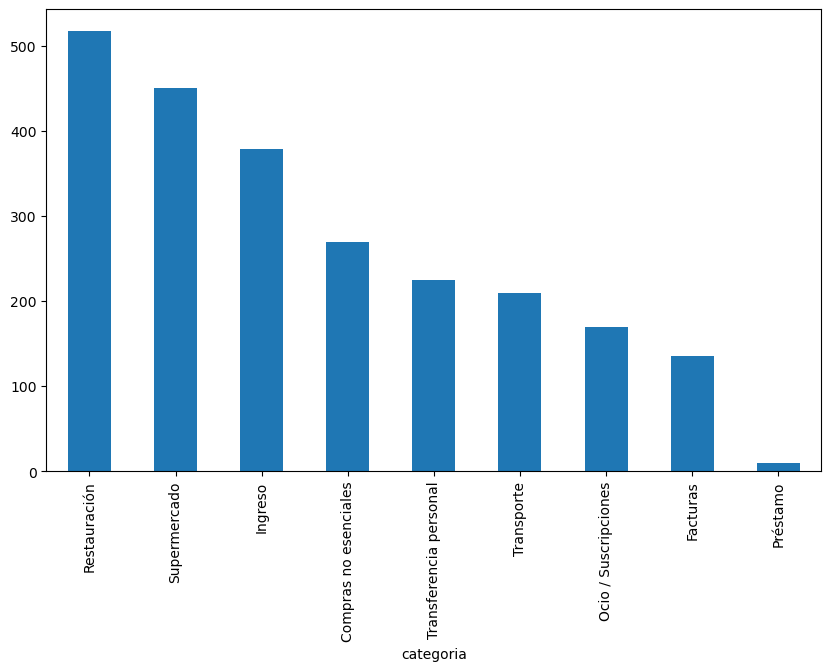

In [18]:
# Ubicamos por categoria
df_categorizado['categoria'].value_counts().plot(kind='bar', figsize=(10,6))

In [19]:
categoria = df_categorizado['categoria'].value_counts()
display(categoria)

categoria
Restauración              517
Supermercado              450
Ingreso                   379
Compras no esenciales     269
Transferencia personal    224
Transporte                209
Ocio / Suscripciones      169
Facturas                  135
Préstamo                   10
Name: count, dtype: int64

In [20]:
#  Pasamos los gastos a valores positivos
df_categorizado['importe'] = df_categorizado['importe'].abs()

In [21]:
#Analizamos los valores de préstamo
prestamo = df_categorizado[df_categorizado['categoria'] == 'Préstamo']
display(prestamo)

,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes,categoria,origen
373,2022-07-17,LIQUIDACION DEL CONTRATO 0003735 300,0.03,liquidacion del contrato,gasto,2022-07,Préstamo,modelo
862,2025-04-01,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2025-04,Préstamo,manual
912,2025-02-28,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2025-02,Préstamo,manual
951,2025-01-31,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2025-01,Préstamo,manual
1001,2024-12-31,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-12,Préstamo,manual
1077,2024-12-02,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-12,Préstamo,manual
1132,2024-10-31,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-10,Préstamo,manual
1197,2024-10-01,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-10,Préstamo,manual
1478,2024-05-20,Liquidacion Del Contrato 0003735 300,0.02,liquidacion del contrato,gasto,2024-05,Préstamo,modelo
2361,2025-03-31,Prestamo,197.19,prestamo,ingreso,2025-03,Préstamo,modelo


In [22]:
resumen_categorias = df_categorizado.groupby('categoria')['importe'].agg(['count', 'sum', 'mean', 'min', 'max']).sort_values('sum', ascending=False)
display(resumen_categorias)

,count,sum,mean,min,max
categoria,,,,,
Ingreso,379,70043.16,184.810449,0.01,8000.00
Transferencia personal,224,24102.96,107.602500,0.02,10400.00
Supermercado,450,9957.82,22.128489,0.35,130.00
Facturas,135,9576.02,70.933481,1.00,342.35
Restauración,517,8126.78,15.719110,0.20,874.00
Compras no esenciales,269,7466.08,27.754944,0.20,797.03
Transporte,209,4596.71,21.993828,0.01,149.82
Ocio / Suscripciones,169,3647.53,21.583018,1.00,1430.05
Préstamo,10,1577.57,157.757000,0.02,197.19


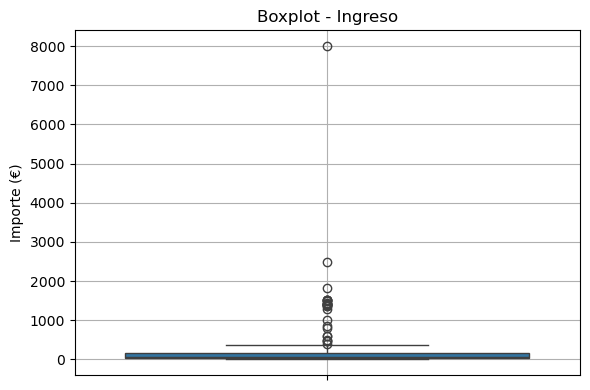

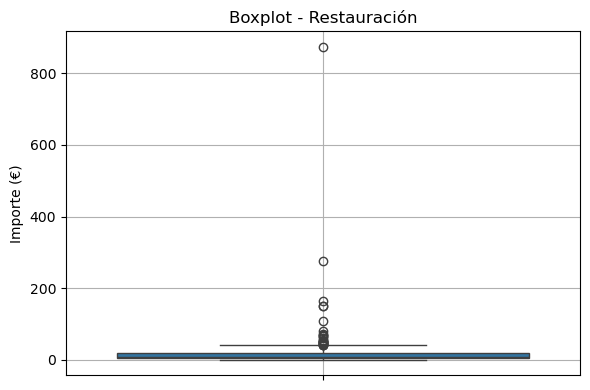

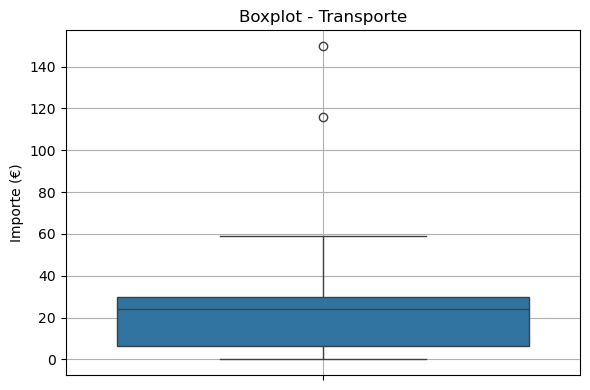

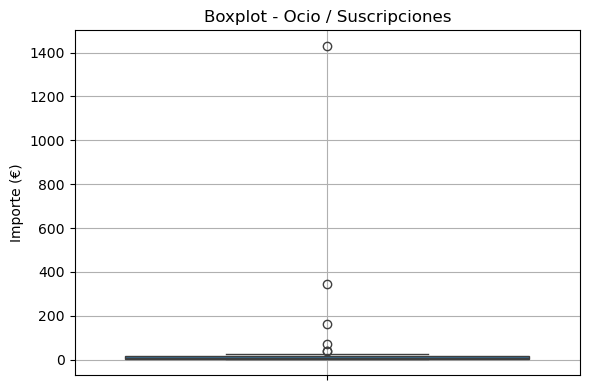

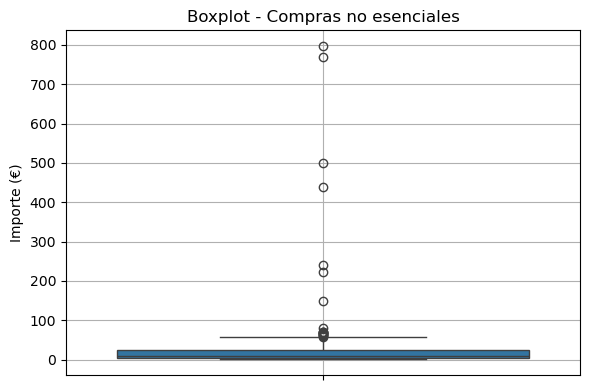

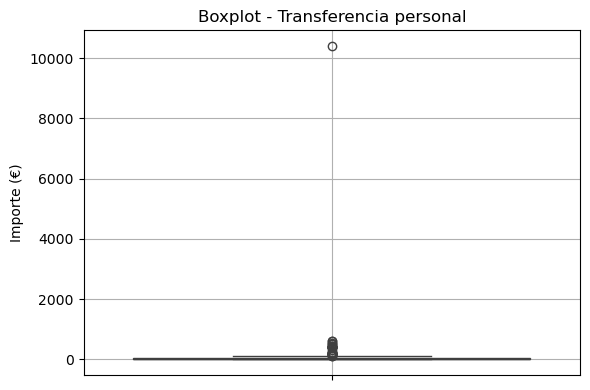

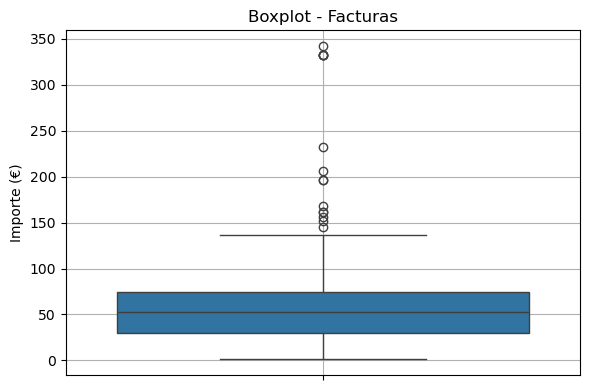

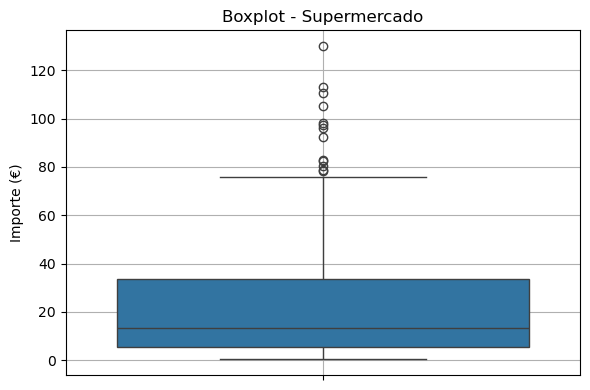

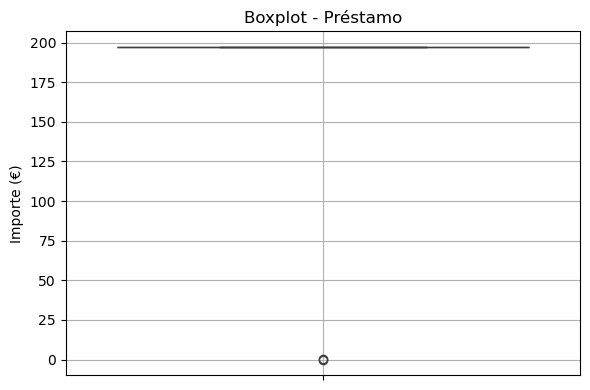

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener las categorías únicas
categorias = df_categorizado['categoria'].unique()

# Crear un gráfico por categoría
for cat in categorias:
    plt.figure(figsize=(6, 4))
    datos = df_categorizado[df_categorizado['categoria'] == cat]

    sns.boxplot(data=datos, y='importe')
    plt.title(f'Boxplot - {cat}')
    plt.ylabel('Importe (€)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [24]:
def mover_outliers_a_gastos_extra(df):
    df = df.copy()

    for cat in df['categoria'].unique():
        datos = df[df['categoria'] == cat]['importe']
        q1, q3 = datos.quantile([0.25, 0.9])
        iqr = q3 - q1
        bajo = q1 - 1.5 * iqr
        alto = q3 + 1.5 * iqr

        es_outlier = (df['categoria'] == cat) & ((df['importe'] < bajo) | (df['importe'] > alto))
        df.loc[es_outlier, 'categoria'] = 'Gastos extraordinarios'

    return df


In [25]:
df_categorizado = mover_outliers_a_gastos_extra(df_categorizado)
df_categorizado['categoria'].value_counts()


categoria
Restauración              510
Supermercado              449
Ingreso                   358
Compras no esenciales     262
Transferencia personal    218
Transporte                207
Ocio / Suscripciones      165
Facturas                  130
Gastos extraordinarios     55
Préstamo                    8
Name: count, dtype: int64

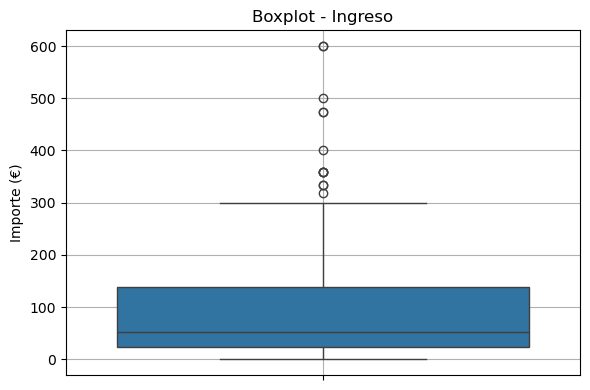

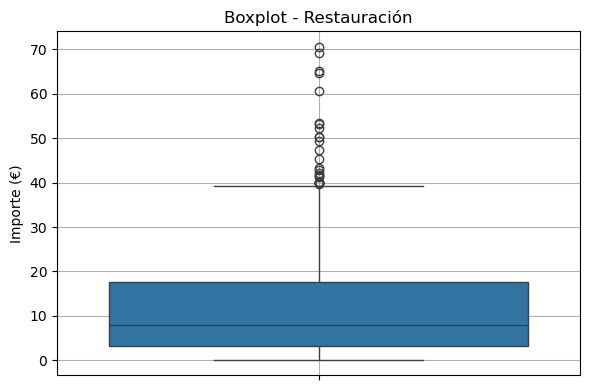

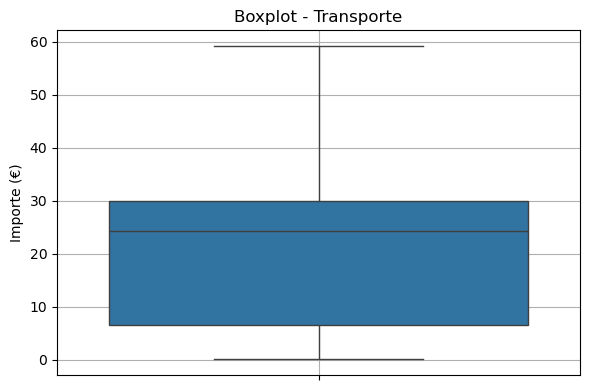

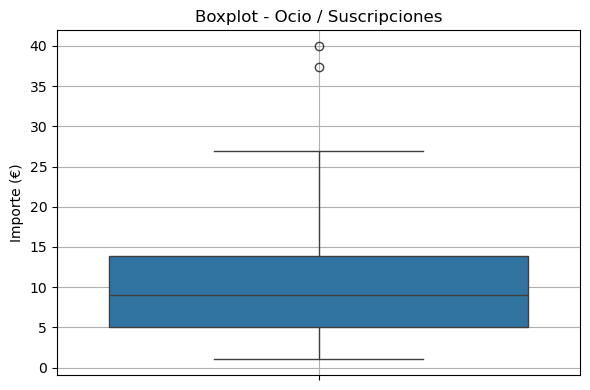

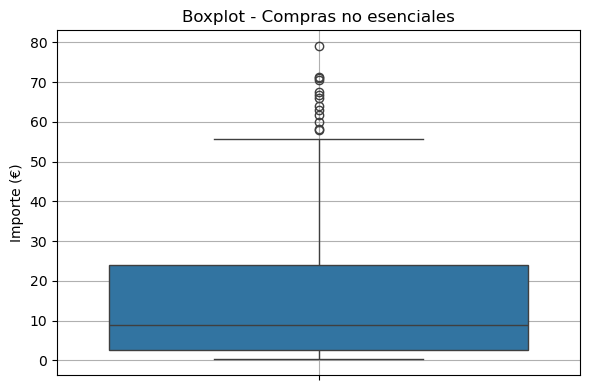

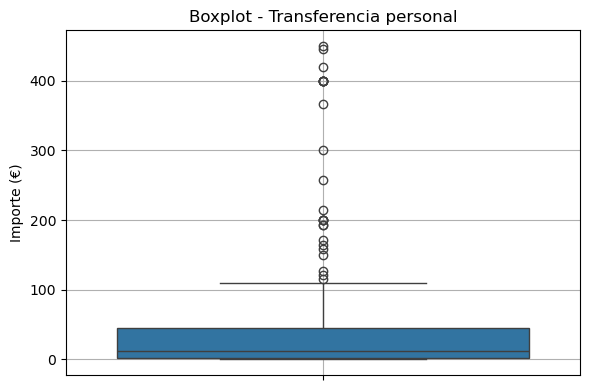

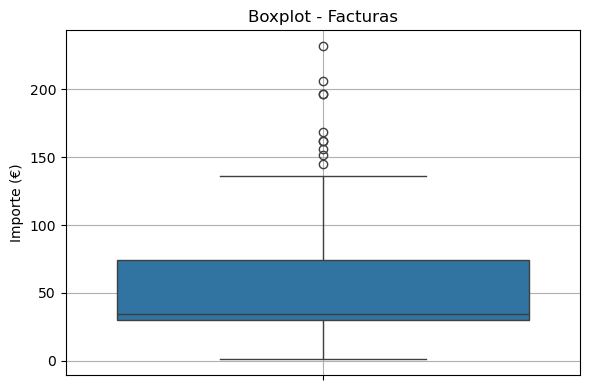

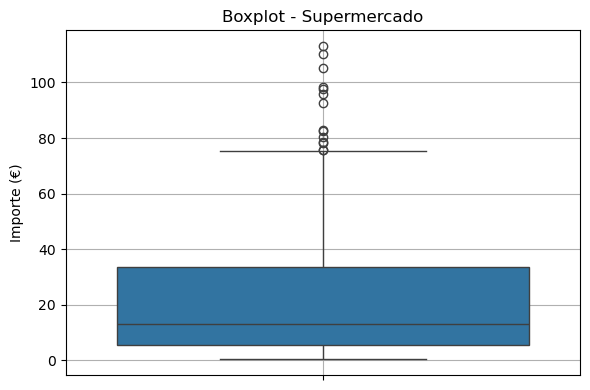

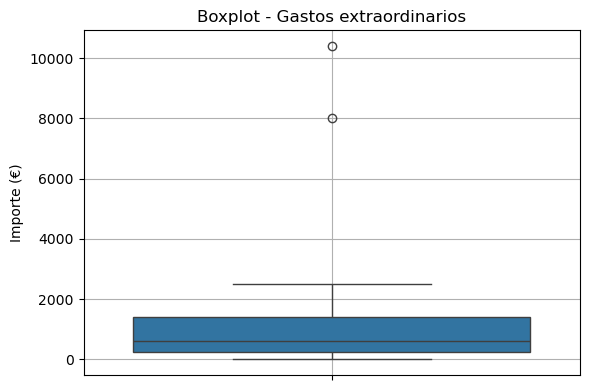

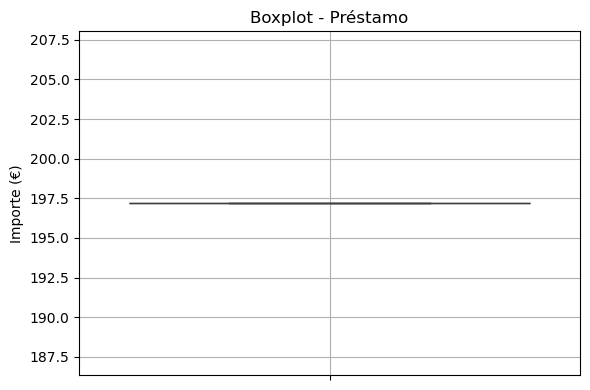

In [26]:
# Obtener las categorías únicas
categorias = df_categorizado['categoria'].unique()

# Crear un gráfico por categoría
for cat in categorias:
    plt.figure(figsize=(6, 4))
    datos = df_categorizado[df_categorizado['categoria'] == cat]

    sns.boxplot(data=datos, y='importe')
    plt.title(f'Boxplot - {cat}')
    plt.ylabel('Importe (€)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


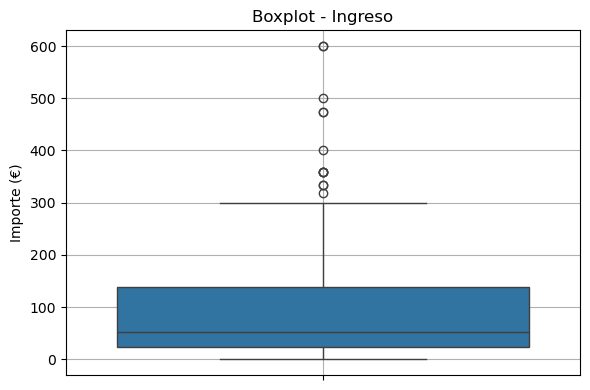

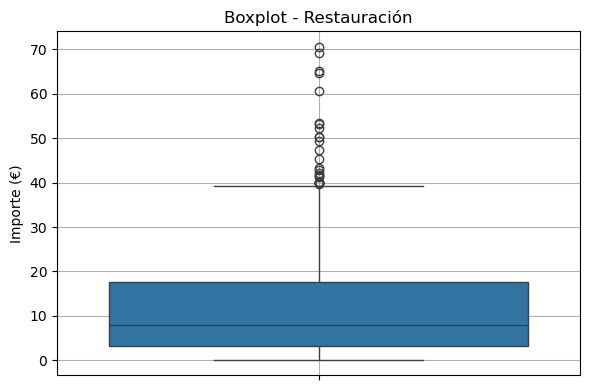

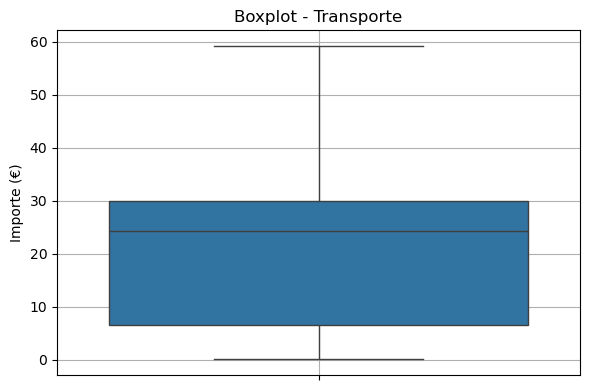

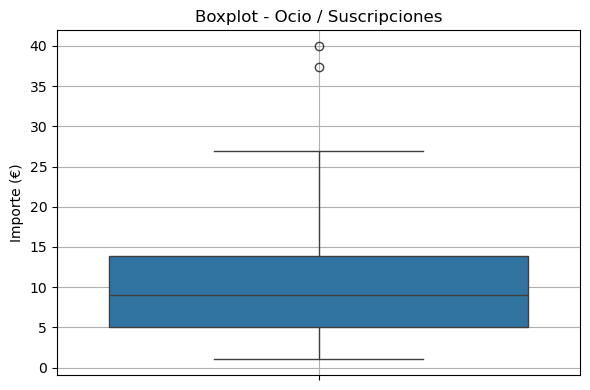

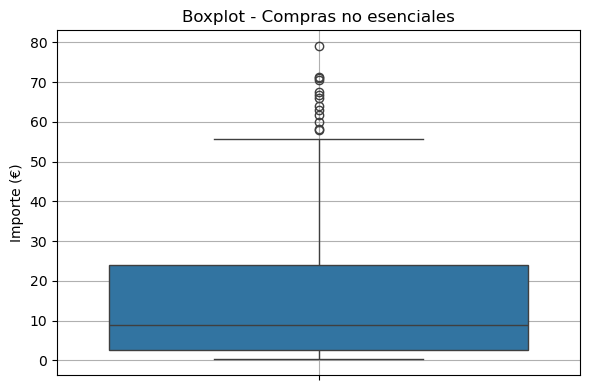

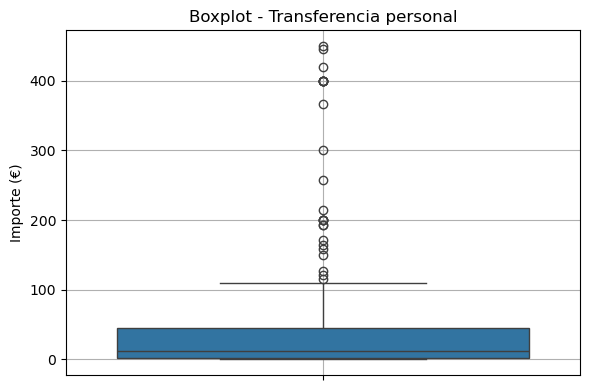

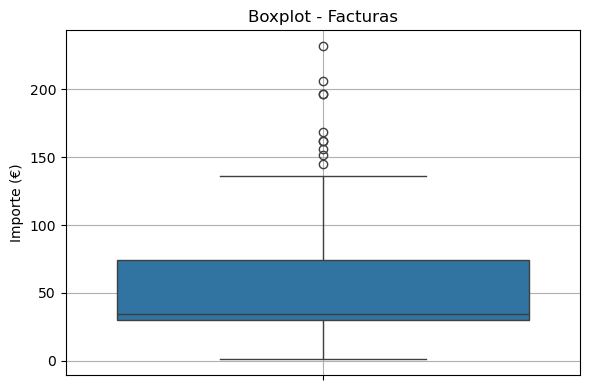

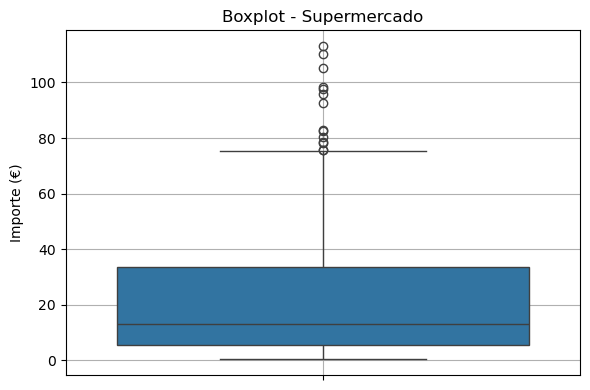

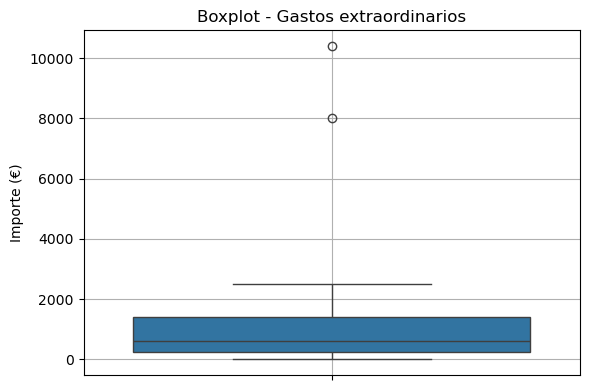

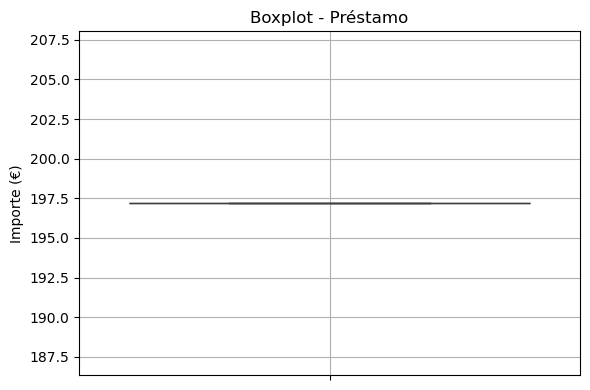

In [27]:
# Obtener las categorías únicas
categorias = df_categorizado['categoria'].unique()

# Crear un gráfico por categoría
for cat in categorias:
    plt.figure(figsize=(6, 4))
    datos = df_categorizado[df_categorizado['categoria'] == cat]

    sns.boxplot(data=datos, y='importe')
    plt.title(f'Boxplot - {cat}')
    plt.ylabel('Importe (€)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [28]:
df_categorizado[df_categorizado['categoria'] == 'Préstamo'].sample(8)



,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes,categoria,origen
951,2025-01-31,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2025-01,Préstamo,manual
862,2025-04-01,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2025-04,Préstamo,manual
1197,2024-10-01,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-10,Préstamo,manual
1001,2024-12-31,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-12,Préstamo,manual
1132,2024-10-31,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-10,Préstamo,manual
2361,2025-03-31,Prestamo,197.19,prestamo,ingreso,2025-03,Préstamo,modelo
1077,2024-12-02,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-12,Préstamo,manual
912,2025-02-28,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2025-02,Préstamo,manual


In [29]:
# Guardar el CSV
df_categorizado.to_csv("Movimientos_categorizados.csv", index=False)